### HALO SAMPLING IN 21cmFAST
This short notebook will run through a few quick examples to show how the halo sampler works. We Will:
- draw halo samples from a density grid, and make sure they match the underlying mass function
- draw halo samples from a descendant catalogue, making sure they match both the expected unconditional mass function and respond to any deviations in the descendant catalogue
- create HII boxes and lightcones using these sources, seeing the effect of halo samples on reionization and cosmic dawn

#### We import a few packages here for plotting and verification

In [1]:
import numpy as np

import py21cmfast as p21c
from py21cmfast import plotting
from py21cmfast import cache_tools
from py21cmfast.c_21cmfast import ffi, lib

from matplotlib import gridspec
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize,LogNorm
plt.rcParams['figure.figsize'] = [12, 6]

from hmf.mass_function import FittingFunction, PS
from hmf.halos import MassDefinition
from hmf import MassFunction

from timeit import default_timer as timer
from datetime import timedelta
from copy import deepcopy

/home/jdavies/.conda/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:57: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/jdavies/.conda/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:41: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


#### For this exercise, we get reference mass functions from the [HMF package](https://github.com/halomod/hmf)

In [2]:
cosmo_params = p21c.CosmoParams()
user_params = p21c.UserParams(HII_DIM=50,BOX_LEN=100,DIM=200,USE_INTERPOLATION_TABLES=True,N_THREADS=1,HMF=0)
astro_params = p21c.AstroParams()
flag_options = p21c.FlagOptions(USE_HALO_FIELD=True,HALO_STOCHASTICITY=True,USE_MASS_DEPENDENT_ZETA=True)

p21c.global_params.HII_FILTER=0

redshift = 8
redshift_update = 10
edges = np.logspace(7,13,num=64)
widths = np.diff(edges)
dlnm = np.log(edges[1:]) - np.log(edges[:-1])
centres = (edges[:-1] * np.exp(dlnm/2)).astype('f4')
volume = user_params.BOX_LEN**3
little_h = cosmo_params.cosmo.H0.to('km s-1 Mpc-1') / 100
random_seed = 24

class mf_delos(FittingFunction):
    _defaults = {"A": 0.658, "b": -0.582, "c": -1.056}
    @property
    def fsigma(self):
        A = self.params["A"]
        b = self.params["b"]
        c = self.params["c"]
        return A * self.sigma**b * np.exp(c / self.sigma**2)
    
mf_pkg_ps = MassFunction(z=redshift, Mmin=7, Mmax=15, cosmo_model=cosmo_params.cosmo, hmf_model="PS", transfer_model='EH')
mf_pkg_ps2 = MassFunction(z=redshift_update, Mmin=7, Mmax=15, cosmo_model=cosmo_params.cosmo, hmf_model="PS", transfer_model='EH')
# mf_pkg_st = MassFunction(z=redshift, Mmin=7, Mmax=15, cosmo_model=cosmo_params.cosmo, hmf_model="SMT", transfer_model='EH')
# mf_pkg_j = MassFunction(z=redshift, Mmin=7, Mmax=15, cosmo_model=cosmo_params.cosmo, hmf_model="Jenkins", transfer_model='EH')
# mf_pkg_d = MassFunction(z=redshift, Mmin=7, Mmax=15, cosmo_model=cosmo_params.cosmo, hmf_model=mf_delos, transfer_model='EH')

In [3]:
init_box = p21c.initial_conditions(user_params=user_params,
                                    cosmo_params=cosmo_params,
                                    random_seed=random_seed)

#### First, Run a single halo catalogue from the density grid and plot the resulting binned mass function

In [4]:
halolist_init = p21c.determine_halo_list(redshift=redshift,
                                         init_boxes=init_box,
                                         user_params=user_params,
                                         cosmo_params=cosmo_params,
                                         astro_params=astro_params,
                                         flag_options=flag_options,
                                         random_seed=random_seed)

/home/jdavies/.conda/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_utils.py:402: UserWarning: The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
  warnings.warn(


findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

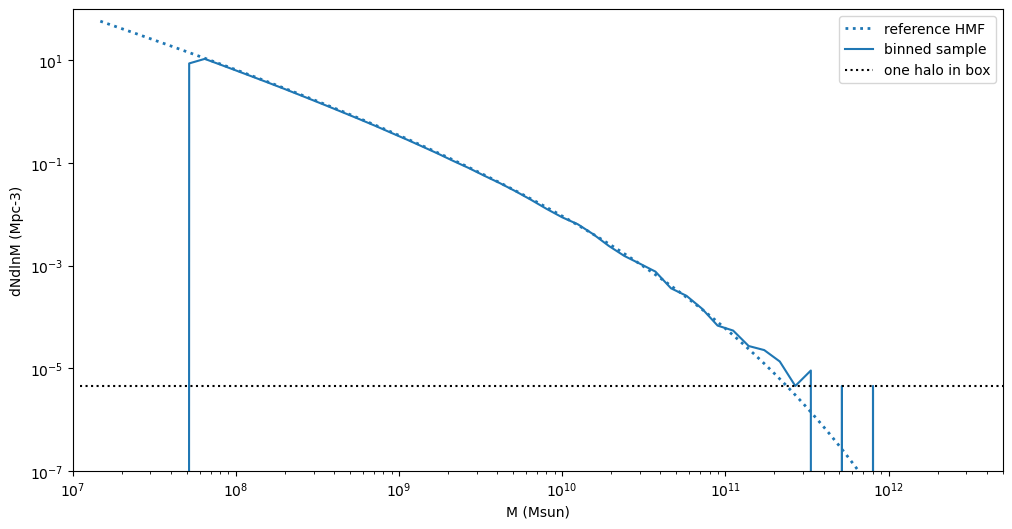

In [5]:
#get the mass function
masses = halolist_init.halo_masses
hist,_ = np.histogram(masses,edges)
mf = hist / volume / dlnm
plt.loglog(mf_pkg_ps.m/little_h,mf_pkg_ps.dndlnm*(little_h**3),color='C0',linewidth=2,linestyle=':',label='reference HMF')
plt.loglog(centres,mf,color='C0',label='binned sample')
plt.loglog(centres,1/volume/dlnm,'k:',label='one halo in box')

plt.xlim([1e7,5e12])
plt.ylim([1e-7,1e2])
plt.ylabel('dNdlnM (Mpc-3)')
plt.xlabel('M (Msun)')
plt.legend()
plt.show()

##### Aside from very high mass halos (This is DexM sampling above the cell mass) Samples follow the expected mass function very closely

#### We can also sample from a previously calculated (descendant) halo list by specifying a new redshift

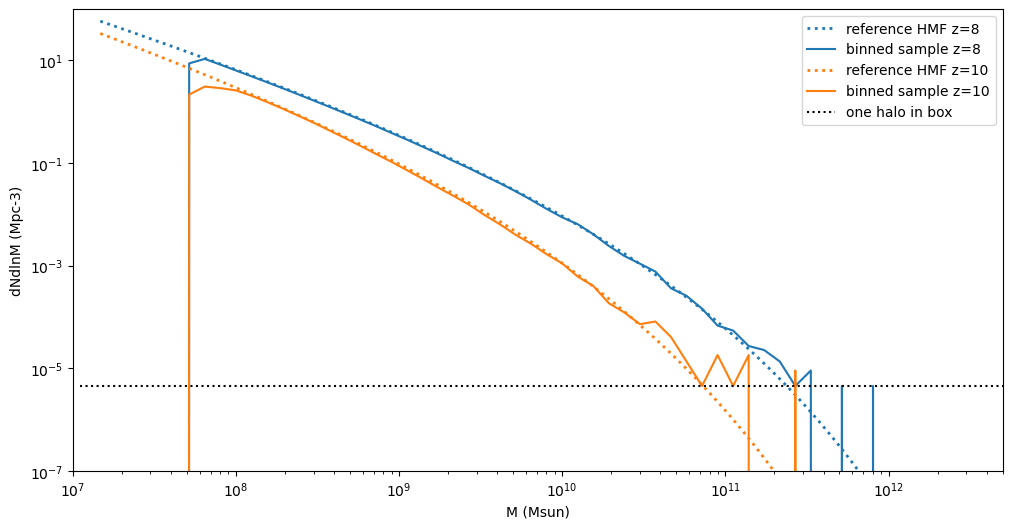

In [6]:
halolist_next = p21c.determine_halo_list(redshift=redshift_update,
                                         init_boxes=init_box,
                                         halos_desc=halolist_init)
#get the mass function
masses = halolist_next.halo_masses
hist,_ = np.histogram(masses,edges)
mf2 = hist / volume / dlnm
plt.loglog(mf_pkg_ps.m/little_h,mf_pkg_ps.dndlnm*(little_h**3),color='C0',linewidth=2,linestyle=':',label=f'reference HMF z={redshift}')
plt.loglog(centres,mf,color='C0',label=f'binned sample z={redshift}')

plt.loglog(mf_pkg_ps2.m/little_h,mf_pkg_ps2.dndlnm*(little_h**3),color='C1',linewidth=2,linestyle=':',label=f'reference HMF z={redshift_update}')
plt.loglog(centres,mf2,color='C1',label=f'binned sample z={redshift_update}')
plt.loglog(centres,1/volume/dlnm,'k:',label='one halo in box')

plt.xlim([1e7,5e12])
plt.ylim([1e-7,1e2])
plt.ylabel('dNdlnM (Mpc-3)')
plt.xlabel('M (Msun)')
plt.legend()
plt.show()

##### Results for the next redshift follow the mass function at z=10, even through they are not explicitly given this mass function

#### If we modify the descendant halo list, we can see how descendant halos effect the progenitor population
In this case, we add 1000 halos of mass 1e11 to see what happens to the progenitor population

In [7]:
halolist_edit = deepcopy(halolist_init)
#add a bunch of large halos to the first catalogue
halomass_edit = halolist_edit.halo_masses
halomass_edit[halolist_edit.n_halos:halolist_edit.n_halos+1000] = 1e11
setattr(halolist_edit,'halo_masses',halomass_edit)
setattr(halolist_edit,'n_halos',halolist_edit.n_halos + 1000)

#call to pass memory to c
halolist_edit()
# print(halolist_edit.n_halos,halolist_init.n_halos)
# print(halolist_edit.halo_masses[halolist_edit.n_halos-15:halolist_edit.n_halos])

#the redshift difference is just a hack so it doesn't read the cache
halolist_next2 = p21c.determine_halo_list(redshift=redshift_update*1.001,
                                         halos_desc=halolist_edit,
                                         init_boxes=init_box,)

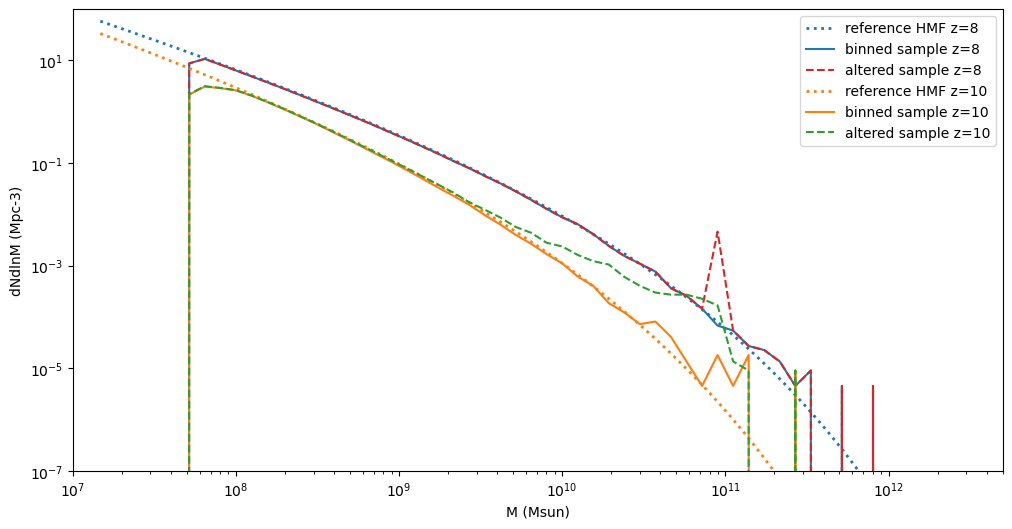

In [8]:
#get the mass function
masses = halolist_next2.halo_masses
hist,_ = np.histogram(masses,edges)
mf3 = hist / volume / dlnm

masses = halolist_edit.halo_masses
hist,_ = np.histogram(masses,edges)
mf4 = hist / volume / dlnm

plt.loglog(mf_pkg_ps.m/little_h,mf_pkg_ps.dndlnm*(little_h**3),color='C0',linewidth=2,linestyle=':',label=f'reference HMF z={redshift}')

plt.loglog(centres,mf,color='C0',label=f'binned sample z={redshift}')
plt.loglog(centres,mf4,color='C3',linestyle='--',label=f'altered sample z={redshift}')


plt.loglog(mf_pkg_ps2.m/little_h,mf_pkg_ps2.dndlnm*(little_h**3),color='C1',linewidth=2,linestyle=':',label=f'reference HMF z={redshift_update}')
plt.loglog(centres,mf2,color='C1',label=f'binned sample z={redshift_update}')

#we should get a bump at higher masses < 1e11
plt.loglog(centres,mf3,color='C2',linestyle='--',label=f'altered sample z={redshift_update}')

plt.xlim([1e7,5e12])
plt.ylim([1e-7,1e2])
plt.ylabel('dNdlnM (Mpc-3)')
plt.xlabel('M (Msun)')
plt.legend()
plt.show()

##### The alteration in the descendant catalogue (red dashed line) is reflected in its progenitors (green dashed line)
We see an increase in higher mass halos just underneath the added descendant mass of 1e11

#### HALO CATALOGUES CAN BE PERTURBED AND GRIDDED

In [9]:
pt_halos = p21c.perturb_halo_list(redshift=redshift,halo_field=halolist_init,init_boxes=init_box)

In [10]:
halo_box = p21c.halo_box(redshift=redshift,pt_halos=pt_halos,init_boxes=init_box)

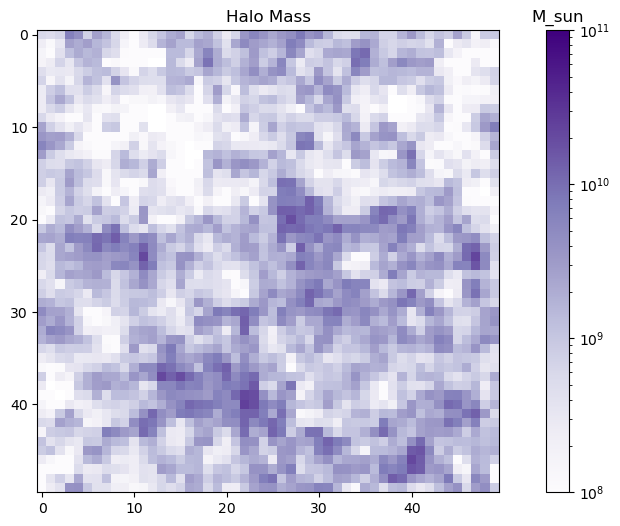

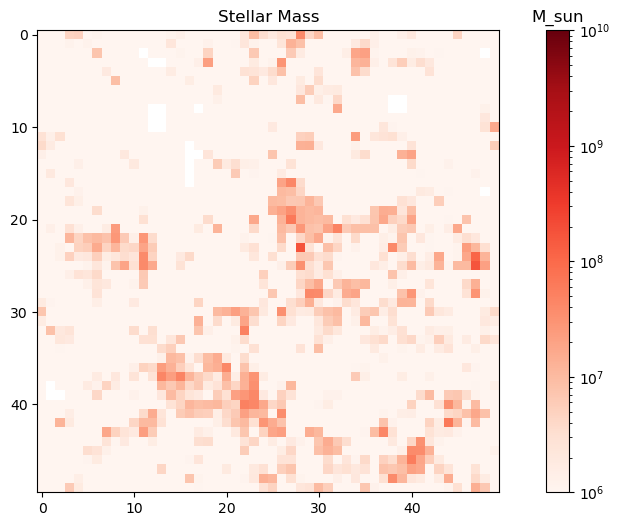

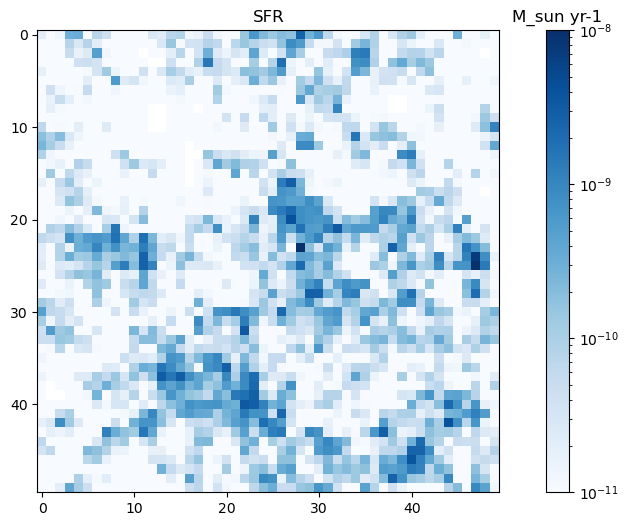

In [11]:
plt.figure()
plt.imshow(halo_box.halo_mass[...,0],cmap=cm.Purples,norm=LogNorm(vmin=1e8,vmax=1e11))
plt.title('Halo Mass')
cb = plt.colorbar()
cb.ax.set_title('M_sun')
plt.show()
plt.imshow(halo_box.halo_stars[...,0],cmap=cm.Reds,norm=LogNorm(vmin=1e6,vmax=1e10))
plt.title('Stellar Mass')
cb = plt.colorbar()
cb.ax.set_title('M_sun')
plt.show()
plt.imshow(halo_box.halo_sfr[...,0],cmap=cm.Blues,norm=LogNorm(vmin=1e-11,vmax=1e-8))
plt.title('SFR')
cb = plt.colorbar()
cb.ax.set_title('M_sun yr-1')
plt.show()

We expect halo mass, stellar mass and SFR to follow a very similar distribution, as all are dependent on the density field

In [12]:
#### These grids can be used instead of the density field when calculating HII maps or spin temperatures

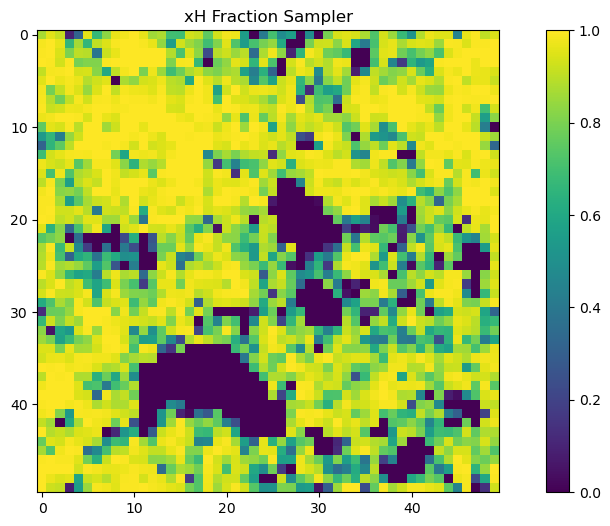

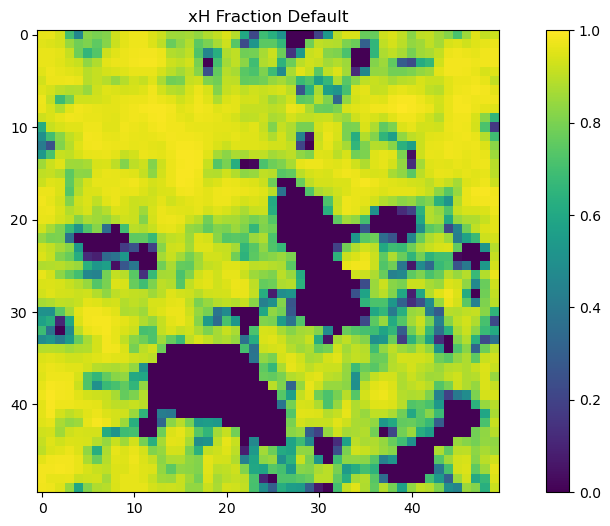

In [13]:
ionbox = p21c.ionize_box(halobox=halo_box)

flag_options_nosampler = flag_options
flag_options_nosampler.update(USE_HALO_FIELD=False,HALO_STOCHASTICITY=False)
ionbox_nosampler = p21c.ionize_box(redshift=redshift,cosmo_params=cosmo_params,user_params=user_params,astro_params=astro_params,flag_options=flag_options_nosampler)

plt.figure()
plt.imshow(ionbox.xH_box[...,0],cmap=cm.viridis,norm=Normalize(vmin=0,vmax=1))
plt.title('xH Fraction Sampler')
plt.colorbar()
plt.show()
plt.imshow(ionbox_nosampler.xH_box[...,0],cmap=cm.viridis,norm=Normalize(vmin=0,vmax=1))
plt.title('xH Fraction Default')
plt.colorbar()
plt.show()

The ionisation field is much noisier on small scales due to much larger variation in stellar mass. but follows the same distribution

In [14]:
#### Full lightcone run with / without halo sampling

/home/jdavies/.conda/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_utils.py:813: UserWarning: Trying to remove array that isn't yet created: hires_vx
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/jdavies/.conda/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_utils.py:813: UserWarning: Trying to remove array that isn't yet created: hires_vy
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/jdavies/.conda/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_utils.py:813: UserWarning: Trying to remove array that isn't yet created: hires_vz
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/jdavies/.conda/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_utils.py:813: UserWarning: Trying to remove array that isn't yet created: hires_vx_2LPT
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/jdavies/.conda/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_util

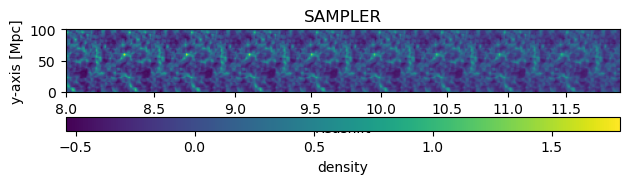

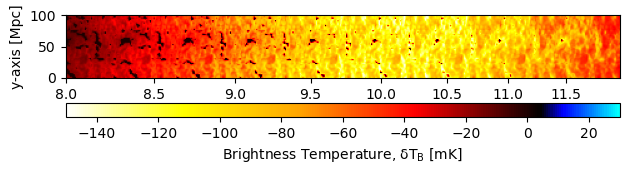

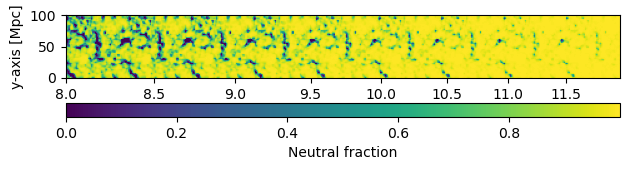

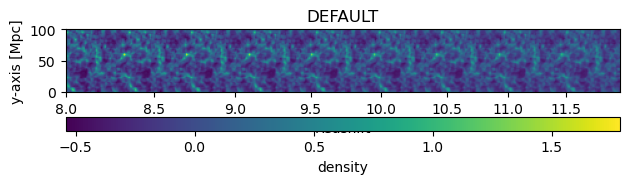

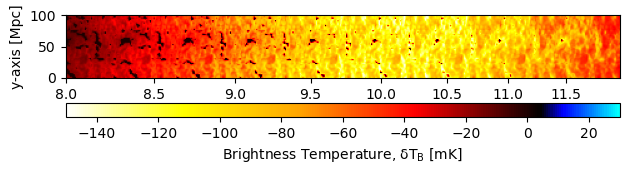

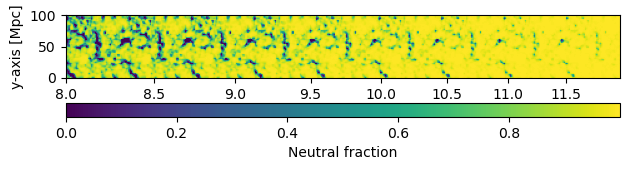

In [15]:
flag_options.update(USE_TS_FLUCT=True)
lightcone_quantities = ["density",'xH_box','brightness_temp']
lc = p21c.run_lightcone(
        redshift = redshift,
        max_redshift = 30,
        flag_options = flag_options,
        astro_params = astro_params,
        user_params = user_params,
        cosmo_params = cosmo_params,
        lightcone_quantities=lightcone_quantities,
        global_quantities=lightcone_quantities,
        random_seed = random_seed,
)
p21c.plotting.lightcone_sliceplot(lc,kind='density',zticks='redshift',aspect='equal'
                                                ,log=False,vertical=False,cbar_horizontal=True
                                                ,z_max=12,slice_index=24)
plt.title('SAMPLER')
plt.show()
p21c.plotting.lightcone_sliceplot(lc,kind='brightness_temp',zticks='redshift',aspect='equal'
                                                ,log=False,vertical=False,cbar_horizontal=True
                                                ,z_max=12,slice_index=24)
plt.show()
p21c.plotting.lightcone_sliceplot(lc,kind='xH_box',zticks='redshift',aspect='equal'
                                                ,log=False,vertical=False,cbar_horizontal=True
                                                ,z_max=12,slice_index=24)
plt.show()
flag_options_nosampler.update(USE_TS_FLUCT=True)

lc_nosampler = p21c.run_lightcone(
        redshift = redshift,
        max_redshift = 30,
        flag_options = flag_options,
        astro_params = astro_params,
        user_params = user_params,
        cosmo_params = cosmo_params,
        lightcone_quantities=lightcone_quantities,
        global_quantities=lightcone_quantities,
        random_seed = random_seed,
)
p21c.plotting.lightcone_sliceplot(lc,kind='density',zticks='redshift',aspect='equal'
                                                ,log=False,vertical=False,cbar_horizontal=True
                                                ,z_max=12,slice_index=24)
plt.title('DEFAULT')
plt.show()
p21c.plotting.lightcone_sliceplot(lc,kind='brightness_temp',zticks='redshift',aspect='equal'
                                                ,log=False,vertical=False,cbar_horizontal=True
                                                ,z_max=12,slice_index=24)
plt.show()
p21c.plotting.lightcone_sliceplot(lc,kind='xH_box',zticks='redshift',aspect='equal'
                                                ,log=False,vertical=False,cbar_horizontal=True
                                                ,z_max=12,slice_index=24)
plt.show()